# Cross-Benchmark Pathway Analysis

This notebook compares pathway results across all benchmark datasets:
1. Retro* (190 molecules)
2. Biomanufacturing Candidates (155 molecules)
3. Kavalactones
4. Roucairol et al.

It loads the pre-computed summary tables from each dataset and visualizes key metrics for comparison.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Matplotlib plot styling (same as analyze_single_benchmark.ipynb)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['figure.dpi'] = 500  # Resolution of figures
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.loc"] = 'best'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = False  # Remove grid lines

## Load Summary Tables from All Datasets

In [23]:
# Define datasets and their paths
datasets = {
    'Retro*': '../results/Retro*/00_pathway_analysis_summary.csv',
    'Biomanufacturing Candidates': '../results/biomanufacturing_candidates/00_pathway_analysis_summary.csv',
    'Kavalactones': '../results/kavalactones/00_pathway_analysis_summary.csv',
    'Roucairol et al.': '../results/Roucairol_et_al/00_pathway_analysis_summary.csv',
}

# Load all summary tables
summaries = {}
for name, path in datasets.items():
    try:
        summaries[name] = pd.read_csv(path)
        print(f"✓ Loaded {name}")
    except FileNotFoundError:
        print(f"✗ NOT FOUND: {name} at {path}")

print(f"\nSuccessfully loaded {len(summaries)} datasets")

✓ Loaded Retro*
✓ Loaded Biomanufacturing Candidates
✓ Loaded Kavalactones
✓ Loaded Roucairol et al.

Successfully loaded 4 datasets


In [24]:
# Extract solve rates from each summary
solve_rates = {}

for name, df in summaries.items():
    # Get total molecules and molecules with pathways
    total_row = df[df['Metric'] == 'Total molecules analyzed']
    solved_row = df[df['Metric'] == 'Molecules with ≥1 successful pathway']
    
    if not total_row.empty and not solved_row.empty:
        total_molecules = int(total_row['Value'].values[0])
        solved_molecules = int(solved_row['Value'].values[0])
        solve_rate = (solved_molecules / total_molecules) * 100
        
        solve_rates[name] = {
            'total': total_molecules,
            'solved': solved_molecules,
            'solve_rate': solve_rate
        }
        print(f"{name}: {solved_molecules}/{total_molecules} = {solve_rate:.1f}%")

print(f"\nExtracted solve rates for {len(solve_rates)} datasets")

Retro*: 20/126 = 15.9%
Biomanufacturing Candidates: 152/154 = 98.7%
Kavalactones: 15/15 = 100.0%
Roucairol et al.: 24/54 = 44.4%

Extracted solve rates for 4 datasets


## Solve Rate Comparison Chart

Figure saved to: ../figures/benchmark_solve_rates.png


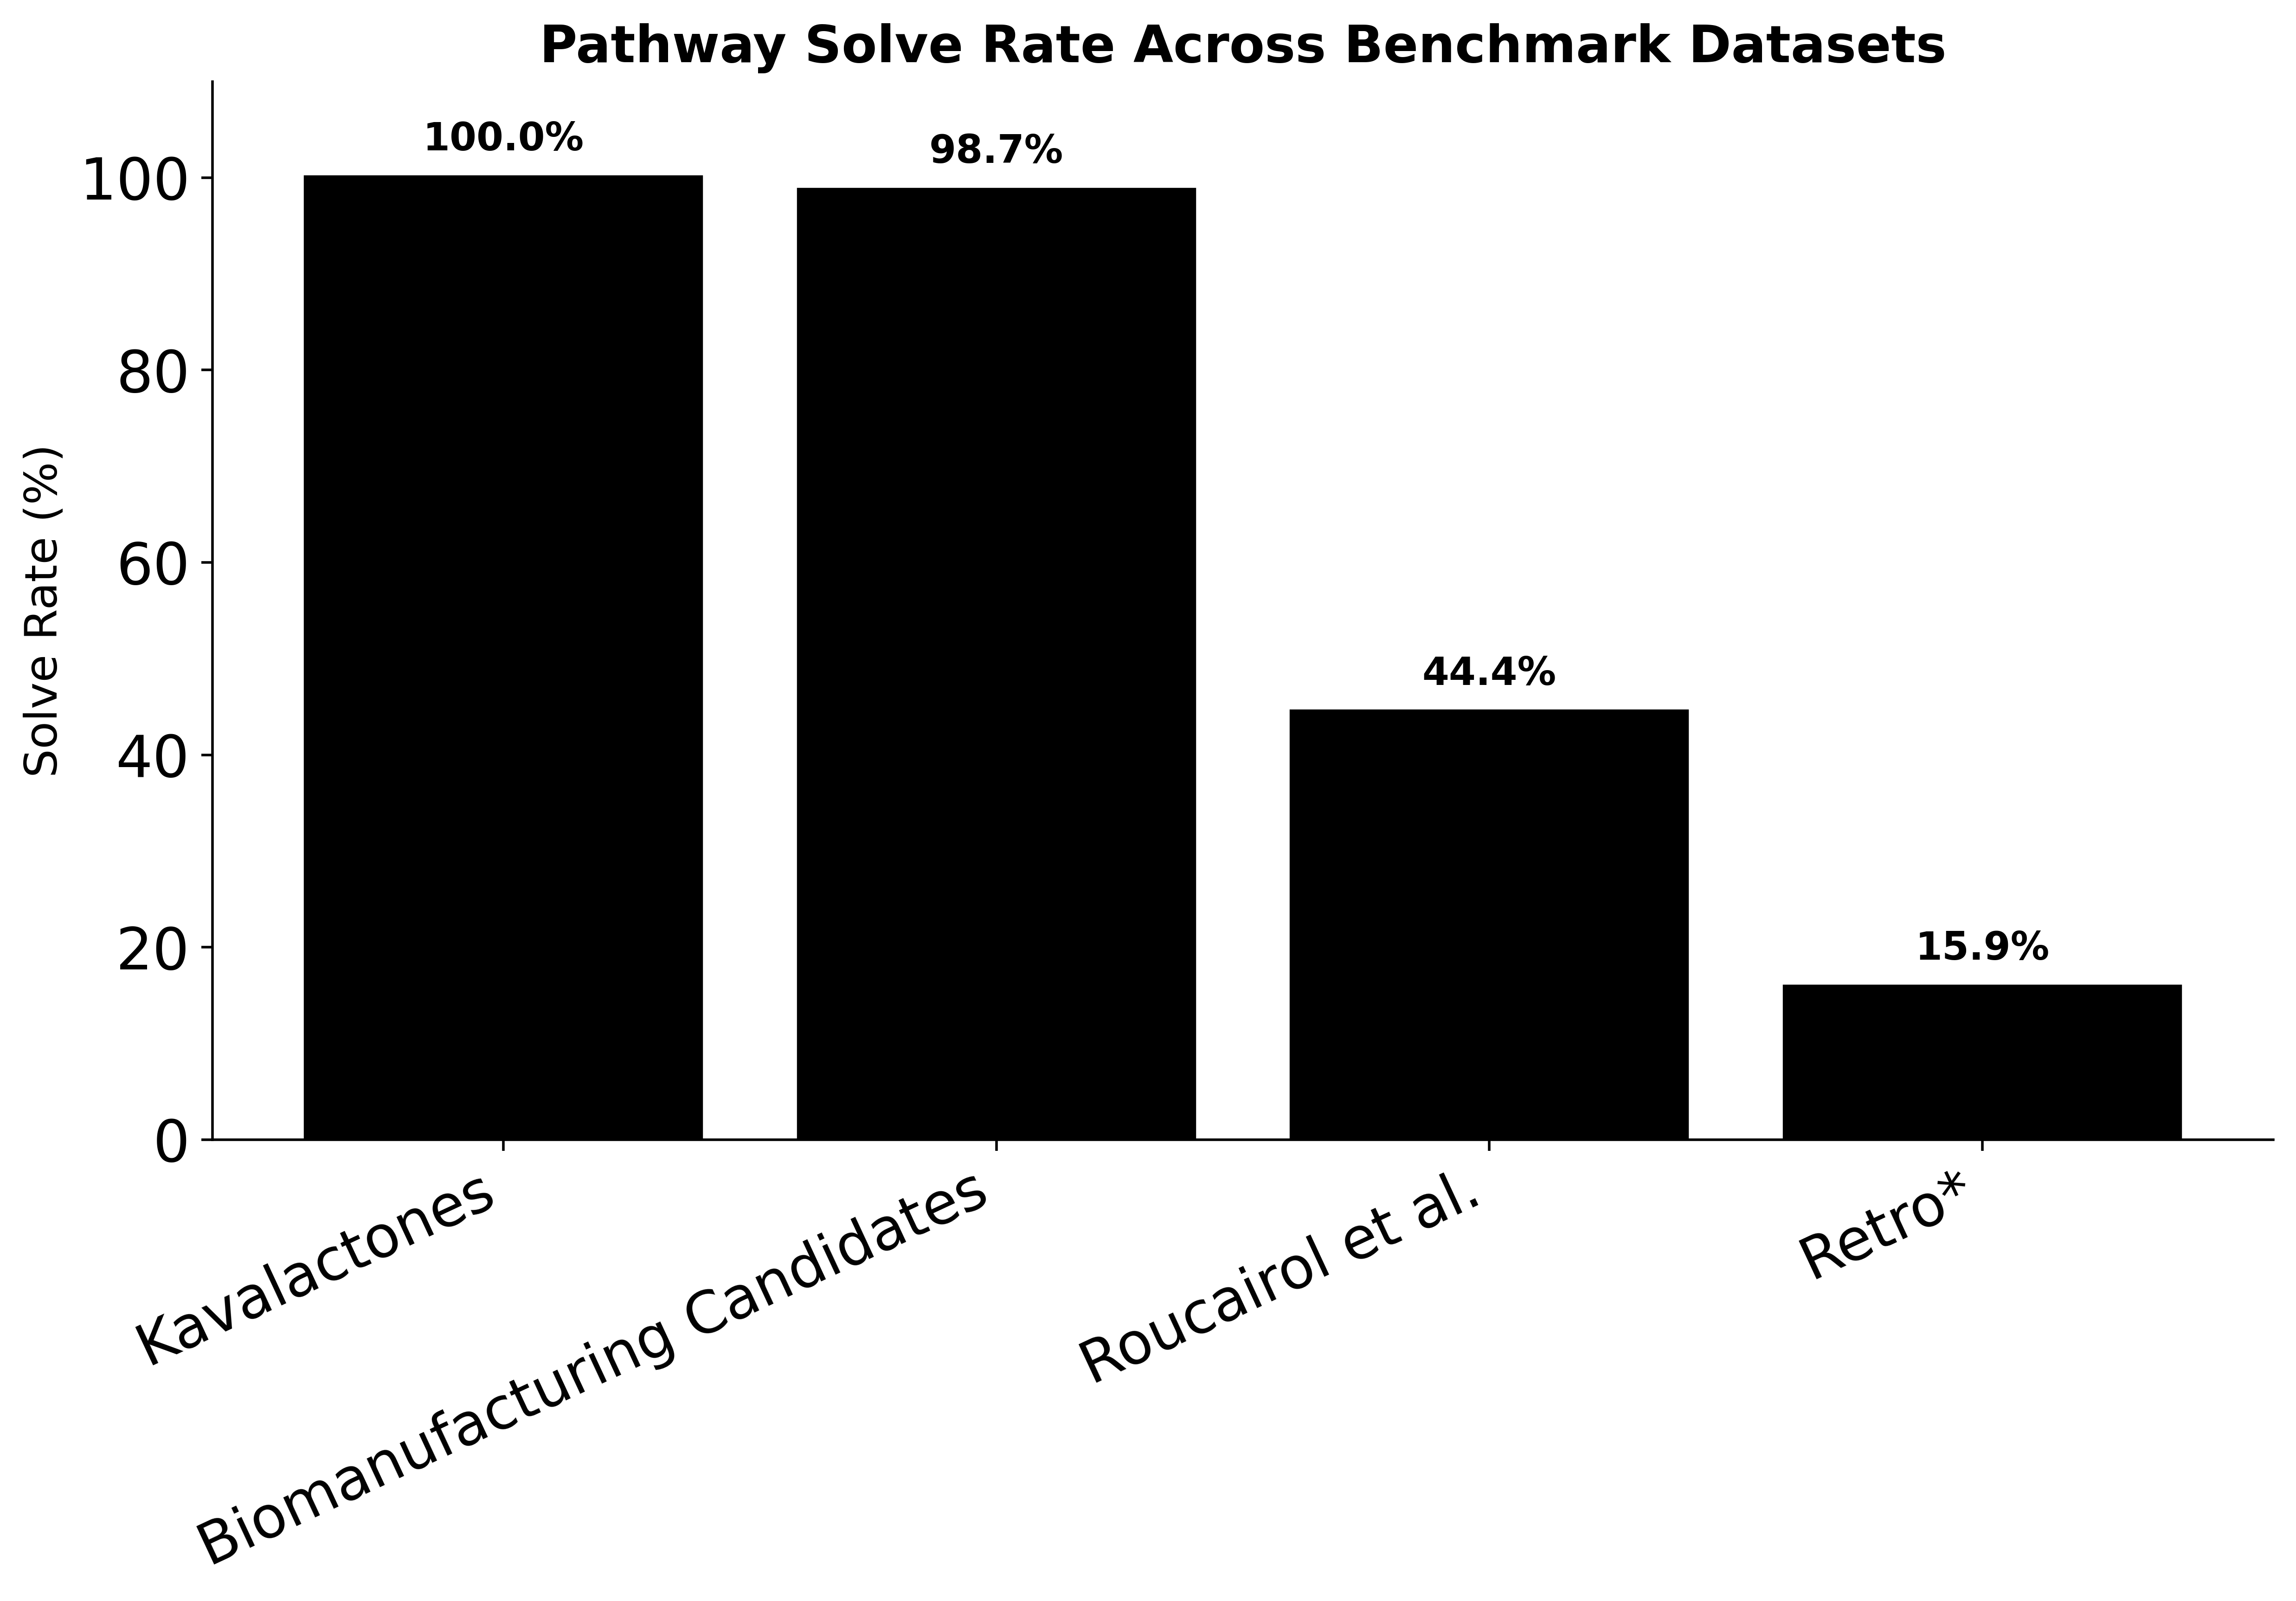

In [25]:
# Create vertical bar chart for solve rates
fig, ax = plt.subplots(figsize=(10, 7))

# Sort data by solve rate (highest to lowest)
sorted_names = sorted(solve_rates.keys(), key=lambda x: solve_rates[x]['solve_rate'], reverse=True)
rates = [solve_rates[name]['solve_rate'] for name in sorted_names]
totals = [solve_rates[name]['total'] for name in sorted_names]
solved = [solve_rates[name]['solved'] for name in sorted_names]

# Create bars with dataset names as x-axis labels
bars = ax.bar(sorted_names, rates, color='black', edgecolor='black', linewidth=1.5)

# Add percentage labels on top of bars (only percentages)
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Formatting
ax.set_ylabel('Solve Rate (%)', fontsize=14)
ax.set_title('Pathway Solve Rate Across Benchmark Datasets', fontsize=16, fontweight='bold')
ax.set_ylim(0, 110)  # Leave room for labels

# Rotate x-axis labels by 25 degrees
plt.xticks(rotation=25, ha='right')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
figures_dir = Path('../figures')
figures_dir.mkdir(parents=True, exist_ok=True)
save_path = figures_dir / 'benchmark_solve_rates.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

In [26]:
# Summary table of all datasets (sorted by solve rate, highest to lowest)
sorted_names = sorted(solve_rates.keys(), key=lambda x: solve_rates[x]['solve_rate'], reverse=True)

summary_comparison = pd.DataFrame([
    {
        'Dataset': name,
        'Total Molecules': solve_rates[name]['total'],
        'Solved Molecules': solve_rates[name]['solved'],
        'Solve Rate (%)': f"{solve_rates[name]['solve_rate']:.1f}%"
    }
    for name in sorted_names
])

print("="*70)
print("BENCHMARK COMPARISON SUMMARY")
print("="*70)
display(summary_comparison)

BENCHMARK COMPARISON SUMMARY


,Dataset,Total Molecules,Solved Molecules,Solve Rate (%)
0,Kavalactones,15,15,100.0%
1,Biomanufacturing Candidates,154,152,98.7%
2,Roucairol et al.,54,24,44.4%
3,Retro*,126,20,15.9%


## t-SNE Visualization of Molecular Embeddings

Visualize the chemical space covered by each benchmark dataset using molecular fingerprints and t-SNE dimensionality reduction.

In [27]:
# Load SMILES for all target molecules from each dataset
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Define paths to the original molecule CSV files
molecule_files = {
    'Retro*': '../data/evaluation/Retro*.csv',
    'Biomanufacturing Candidates': '../data/evaluation/biomanufacturing_candidates.csv',
    'Kavalactones': '../data/evaluation/kavalactones.csv',
    'Roucairol et al.': '../data/evaluation/Roucairol_et_al.csv',
}

# Load all molecules
all_molecules = []
for dataset_name, filepath in molecule_files.items():
    try:
        df = pd.read_csv(filepath)
        # Handle different column names
        if 'cleaned_SMILES' in df.columns:
            smiles_col = 'cleaned_SMILES'
        elif 'SMILES' in df.columns:
            smiles_col = 'SMILES'
        elif 'smiles' in df.columns:
            smiles_col = 'smiles'
        else:
            print(f"Could not find SMILES column in {dataset_name}")
            print(f"  Columns: {df.columns.tolist()}")
            continue
        
        for _, row in df.iterrows():
            all_molecules.append({
                'dataset': dataset_name,
                'smiles': row[smiles_col],
                'label': row.get('molecule_label', row.get('name', ''))
            })
        print(f"✓ Loaded {len(df)} molecules from {dataset_name}")
    except Exception as e:
        print(f"✗ Error loading {dataset_name}: {e}")

print(f"\nTotal molecules loaded: {len(all_molecules)}")

✓ Loaded 190 molecules from Retro*
✓ Loaded 155 molecules from Biomanufacturing Candidates
✓ Loaded 14 molecules from Kavalactones
✓ Loaded 60 molecules from Roucairol et al.

Total molecules loaded: 419


In [28]:
# Compute Morgan fingerprints for all molecules
def smiles_to_fingerprint(smiles, radius=2, n_bits=2048):
    """Convert SMILES to Morgan fingerprint."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        return np.array(fp)
    except Exception as e:
        return None

# Compute fingerprints
fingerprints = []
valid_molecules = []

for mol_data in all_molecules:
    fp = smiles_to_fingerprint(mol_data['smiles'])
    if fp is not None:
        fingerprints.append(fp)
        valid_molecules.append(mol_data)
    else:
        print(f"Warning: Could not process SMILES: {mol_data['smiles'][:50]}...")

fingerprints = np.array(fingerprints)
print(f"\nSuccessfully computed fingerprints for {len(fingerprints)} molecules")
print(f"Fingerprint shape: {fingerprints.shape}")


Successfully computed fingerprints for 415 molecules
Fingerprint shape: (415, 2048)


[22:04:49] SMILES Parse Error: extra open parentheses for input: 'CC=CC(O)CC=CCC(C)C(O)CC(=O)NCC(O)C(C)C(=O)NCCCC2OC1(CCCC(CCC(CC=C(C)C(C)O)O1)CCC2C'
[22:04:49] SMILES Parse Error: extra open parentheses for input: 'CCCC(NC(=O)C1CC2CN1C(=O)C(C(C)(C)C)NC(=O)Cc3cccc'
[22:04:49] SMILES Parse Error: extra open parentheses for input: 'COC4C(O)C(C)OC(OCC3C=CC=CC(=O)C(C)CC(C)'
[22:04:49] SMILES Parse Error: unclosed ring for input: 'CCC7(C4OC(C3OC2(COC(c1ccc(OC)cc1)O2)C(C)CC3C)CC4C)'


In [29]:
# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE

# t-SNE parameters
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    learning_rate='auto',
    init='pca'
)

print("Running t-SNE... (this may take a moment)")
embeddings_2d = tsne.fit_transform(fingerprints)
print(f"t-SNE complete. Output shape: {embeddings_2d.shape}")

Running t-SNE... (this may take a moment)
t-SNE complete. Output shape: (415, 2)
t-SNE complete. Output shape: (415, 2)


Figure saved to: ../figures/benchmark_tsne_by_dataset.png


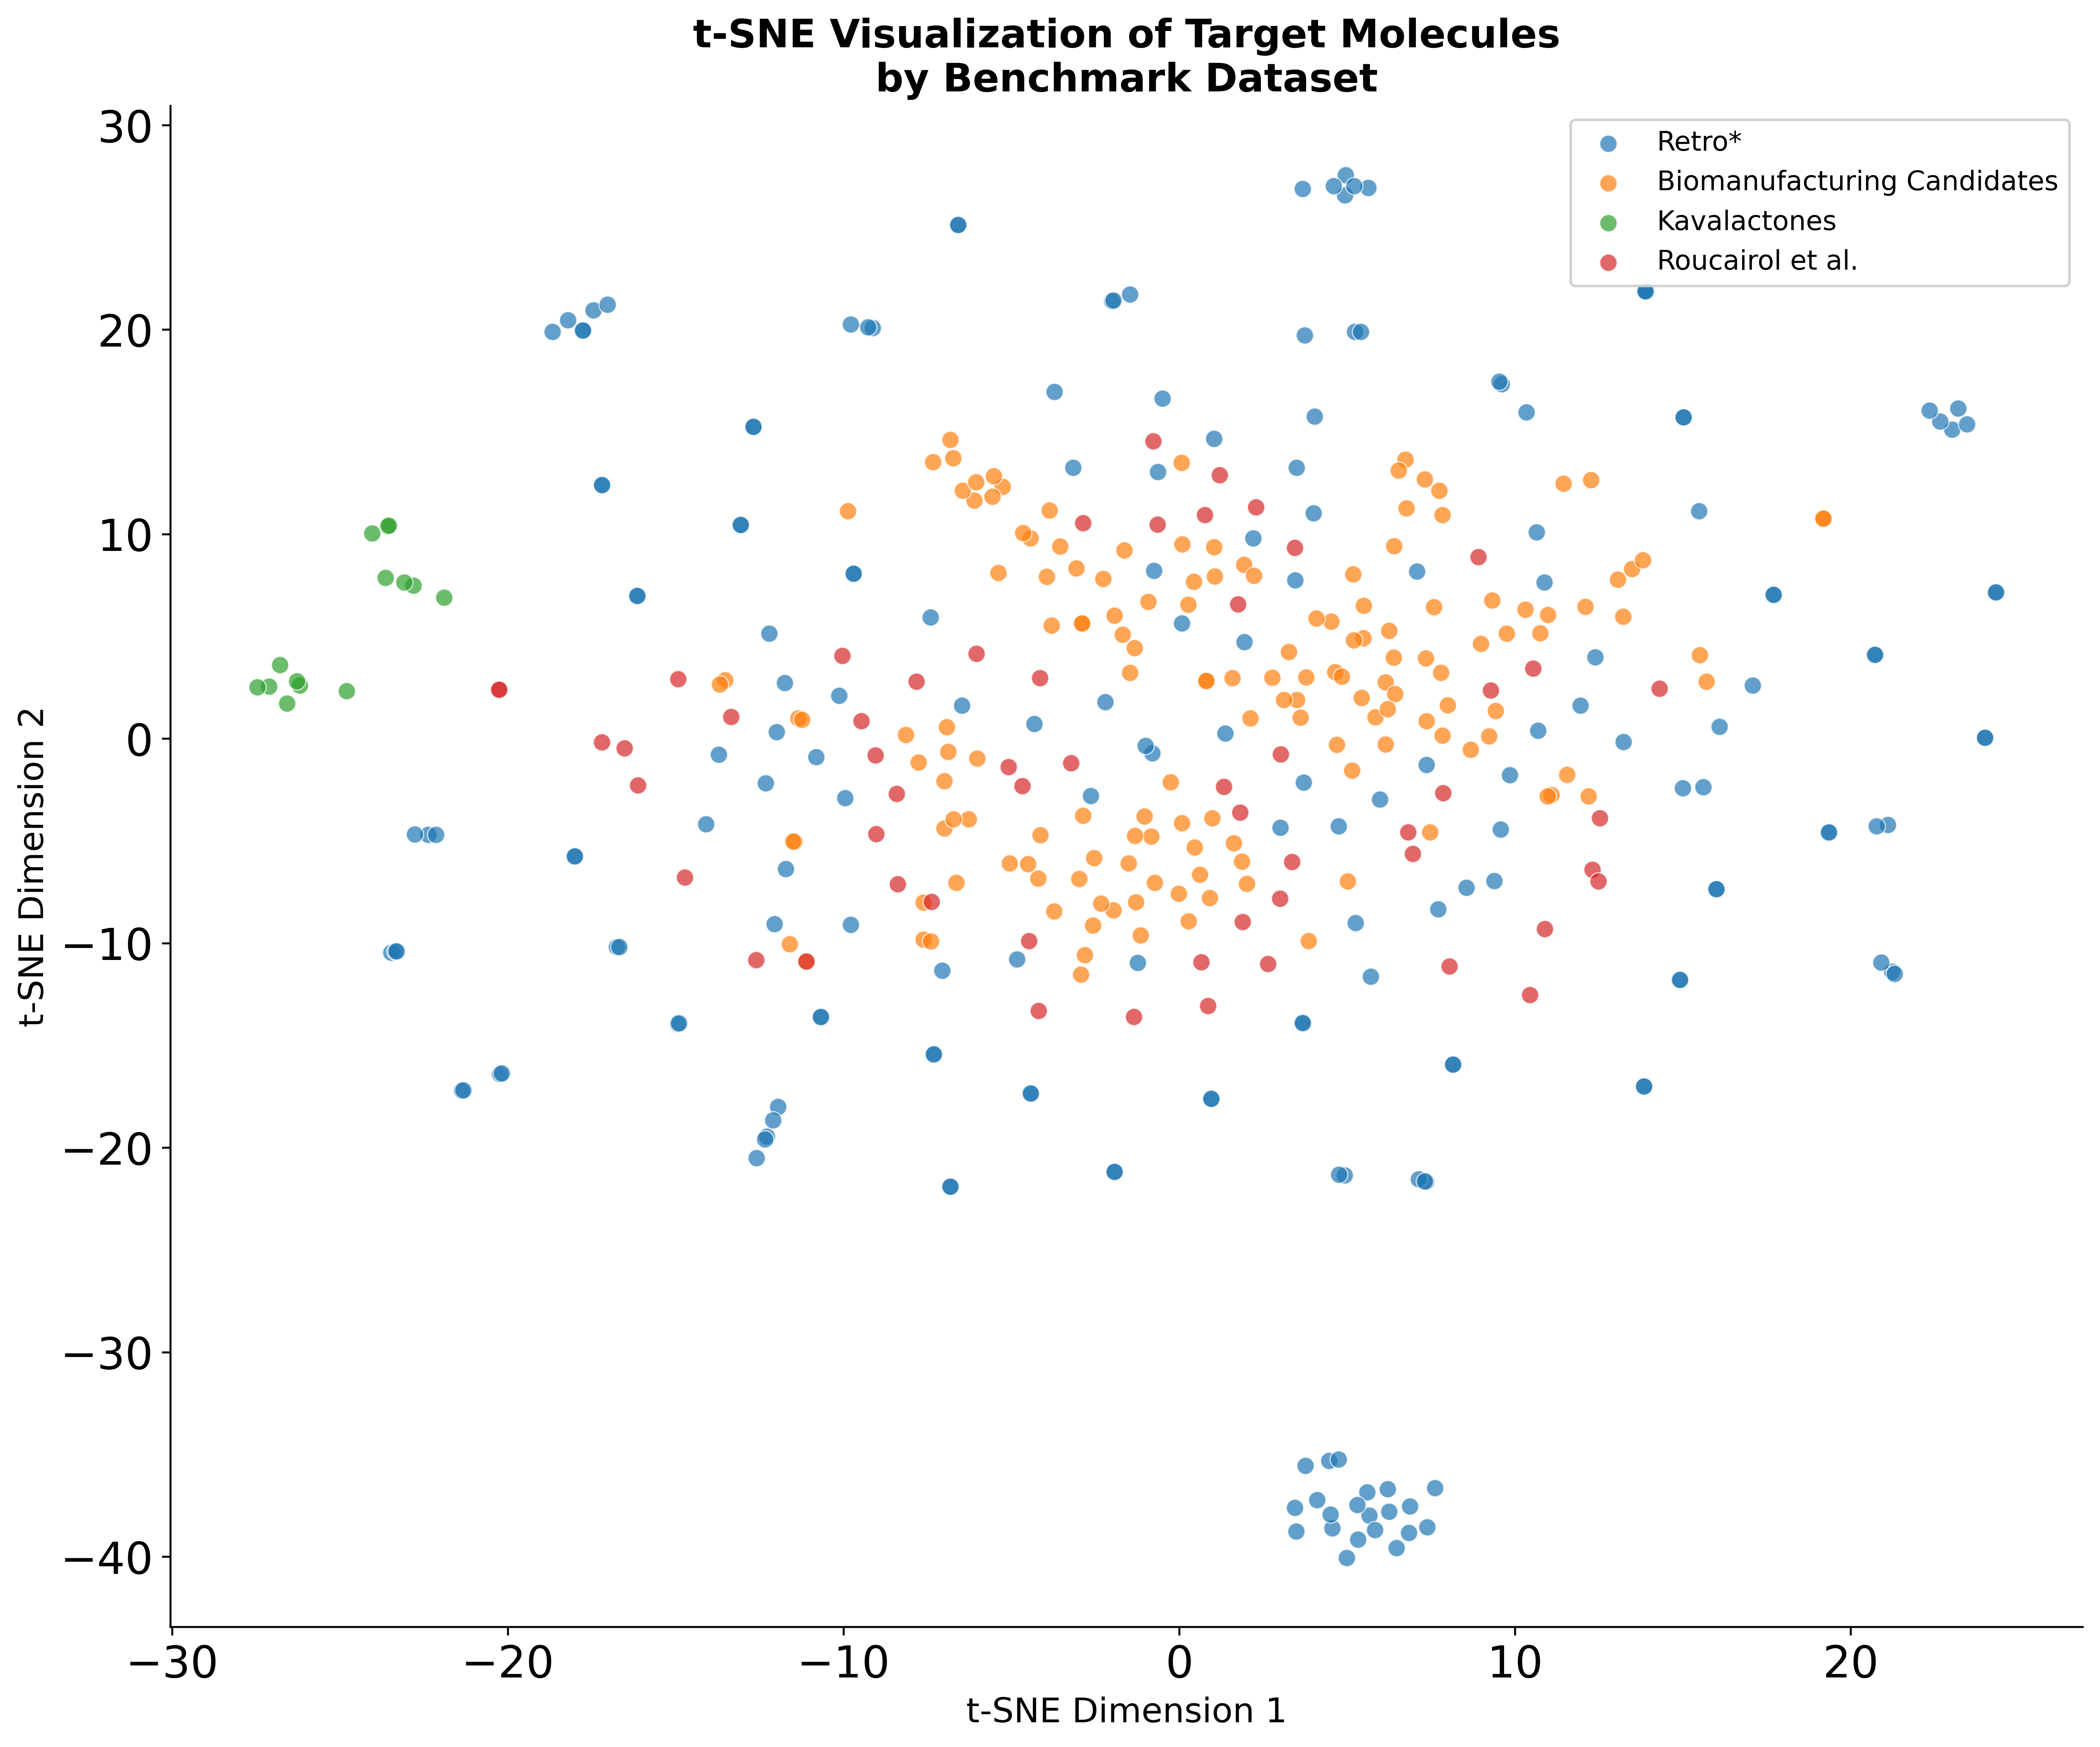

In [30]:
# Create t-SNE scatter plot colored by dataset
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors for each dataset
dataset_colors = {
    'Retro*': '#1f77b4',           # Blue
    'Biomanufacturing Candidates': '#ff7f0e',  # Orange
    'Kavalactones': '#2ca02c',     # Green
    'Roucairol et al.': '#d62728', # Red
}

# Extract dataset labels
datasets_labels = [mol['dataset'] for mol in valid_molecules]

# Plot each dataset separately for legend
for dataset_name, color in dataset_colors.items():
    mask = [d == dataset_name for d in datasets_labels]
    if sum(mask) > 0:
        x_coords = embeddings_2d[mask, 0]
        y_coords = embeddings_2d[mask, 1]
        ax.scatter(x_coords, y_coords, 
                   c=color, 
                   label=dataset_name,
                   alpha=0.7,
                   s=50,
                   edgecolors='white',
                   linewidths=0.5)

# Formatting
ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
ax.set_title('t-SNE Visualization of Target Molecules\nby Benchmark Dataset', 
             fontsize=16, fontweight='bold')

# Legend
ax.legend(loc='best', fontsize=11, framealpha=0.9)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
save_path = figures_dir / 'benchmark_tsne_by_dataset.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## UMAP Visualization of Molecular Embeddings

UMAP (Uniform Manifold Approximation and Projection) is another dimensionality reduction technique that often preserves both local and global structure better than t-SNE.

In [31]:
# Perform UMAP dimensionality reduction
try:
    import umap
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'umap-learn'])
    import umap

# UMAP parameters
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric='jaccard',  # Good for binary fingerprints
    random_state=42)

print("Running UMAP... (this may take a moment)")
umap_embeddings_2d = umap_reducer.fit_transform(fingerprints)
print(f"UMAP complete. Output shape: {umap_embeddings_2d.shape}")

Running UMAP... (this may take a moment)


/Users/yashchainani/miniforge3/envs/MCTS_py311_env/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/yashchainani/miniforge3/envs/MCTS_py311_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP complete. Output shape: (415, 2)


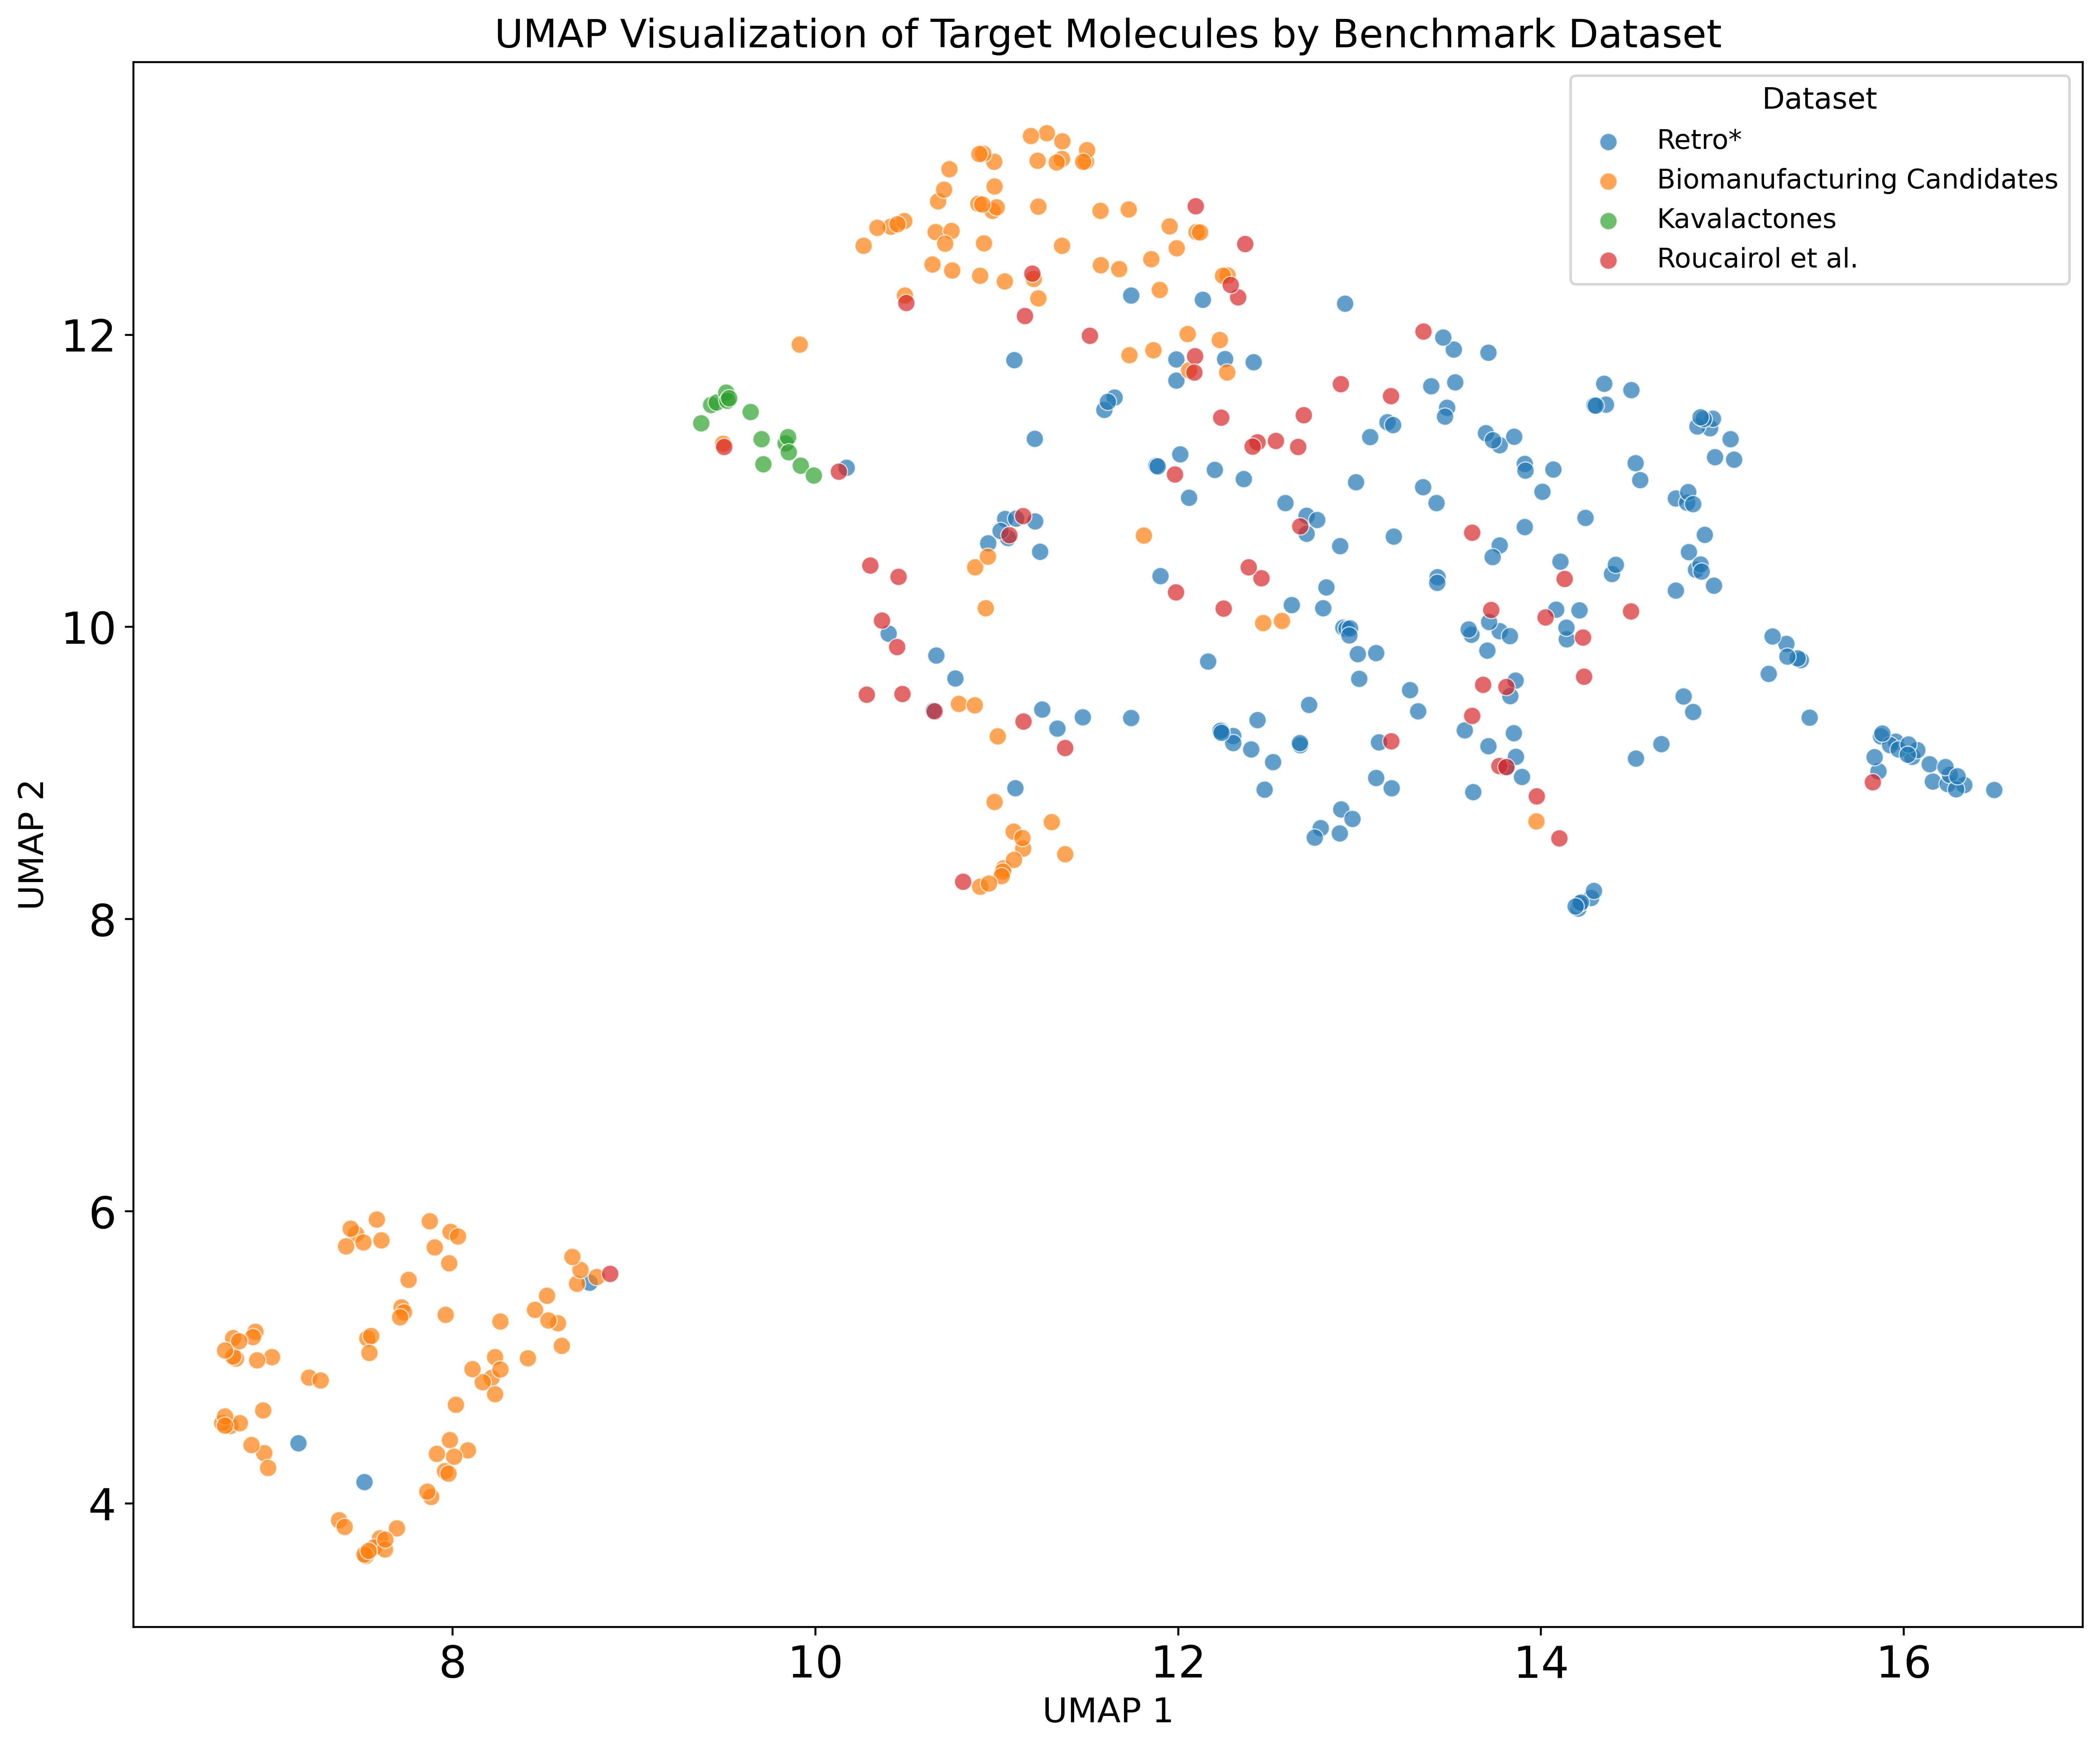

UMAP plot saved to ../figures/benchmark_umap_by_dataset.png


In [32]:
# Create UMAP scatter plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each dataset with its color
for dataset_name, color in dataset_colors.items():
    # Get indices for this dataset
    indices = [i for i, mol in enumerate(valid_molecules) if mol['dataset'] == dataset_name]
    if indices:
        x_coords = umap_embeddings_2d[indices, 0]
        y_coords = umap_embeddings_2d[indices, 1]
        ax.scatter(x_coords, y_coords, c=color, label=dataset_name, alpha=0.7, s=50, edgecolors='white', linewidths=0.5)

ax.set_xlabel('UMAP 1', fontsize=14)
ax.set_ylabel('UMAP 2', fontsize=14)
ax.set_title('UMAP Visualization of Target Molecules by Benchmark Dataset', fontsize=16)
ax.legend(title='Dataset', fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.savefig(figures_dir / 'benchmark_umap_by_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"UMAP plot saved to {figures_dir / 'benchmark_umap_by_dataset.png'}")